In [1]:
import pandas as pd

# Step 1: Load dataset
df = pd.read_csv("cs-training.csv")

# Step 2: Drop the unnecessary index column
df.drop(columns=["Unnamed: 0"], inplace=True)

# Step 3: Handle missing values
# - Fill MonthlyIncome with median
# - Fill NumberOfDependents with mode
df = df.fillna({
    'MonthlyIncome': df['MonthlyIncome'].median(),
    'NumberOfDependents': df['NumberOfDependents'].mode()[0]
})

# Step 4: Remove invalid rows
# - Remove entries with age <= 0
df = df[df['age'] > 0]

# Step 5: Cap outliers
# a. Cap RevolvingUtilizationOfUnsecuredLines to 1.0
df['RevolvingUtilizationOfUnsecuredLines'] = df['RevolvingUtilizationOfUnsecuredLines'].apply(lambda x: min(x, 1.0))

# b. Cap DebtRatio and MonthlyIncome at their 99th percentiles
debt_ratio_cap = df['DebtRatio'].quantile(0.99)
income_cap = df['MonthlyIncome'].quantile(0.99)
df['DebtRatio'] = df['DebtRatio'].apply(lambda x: min(x, debt_ratio_cap))
df['MonthlyIncome'] = df['MonthlyIncome'].apply(lambda x: min(x, income_cap))

# c. Cap NumberOfDependents to max 10
df['NumberOfDependents'] = df['NumberOfDependents'].apply(lambda x: min(x, 10))

# d. Cap delinquency counts to 10 (for stability)
for col in ['NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse']:
    df[col] = df[col].apply(lambda x: min(x, 10))

# Step 6: Drop duplicates
df.drop_duplicates(inplace=True)

# Final check
print("Cleaned dataset shape:", df.shape)
df.head()


Cleaned dataset shape: (149229, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,23000.0,7,0,1,0,0.0


In [2]:
df.to_csv("cleaned_cs-training")

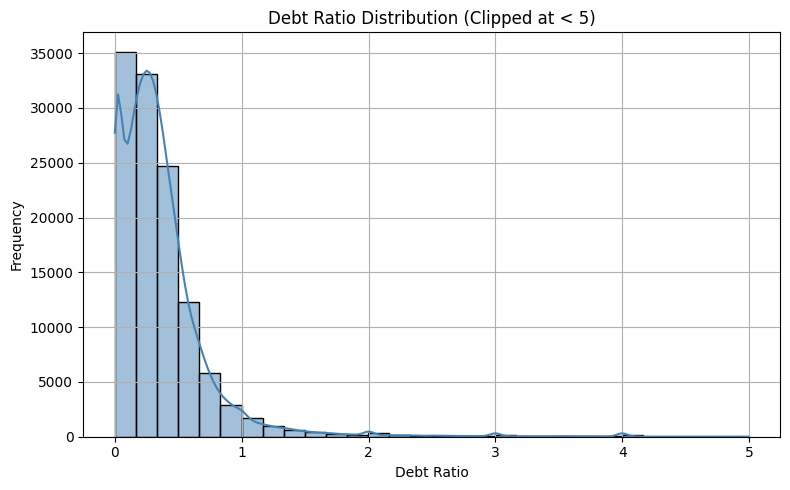

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(data=df[df['DebtRatio'] < 5], x='DebtRatio', bins=30, kde=True, color='steelblue')  # Filter applied here
plt.title('Debt Ratio Distribution (Clipped at < 5)')
plt.xlabel('Debt Ratio')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/rf/7mxkckvj67n75dgt_jp9hz400000gn/T/ipykernel_43227/1133892328.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_default = df.groupby('age_group')['SeriousDlqin2yrs'].mean().reset_index()
/var/folders/rf/7mxkckvj67n75dgt_jp9hz400000gn/T/ipykernel_43227/1133892328.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 0], data=age_default, x='age_group', y='SeriousDlqin2yrs', palette='viridis')
/var/folders/rf/7mxkckvj67n75dgt_jp9hz400000gn/T/ipykernel_43227/1133892328.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

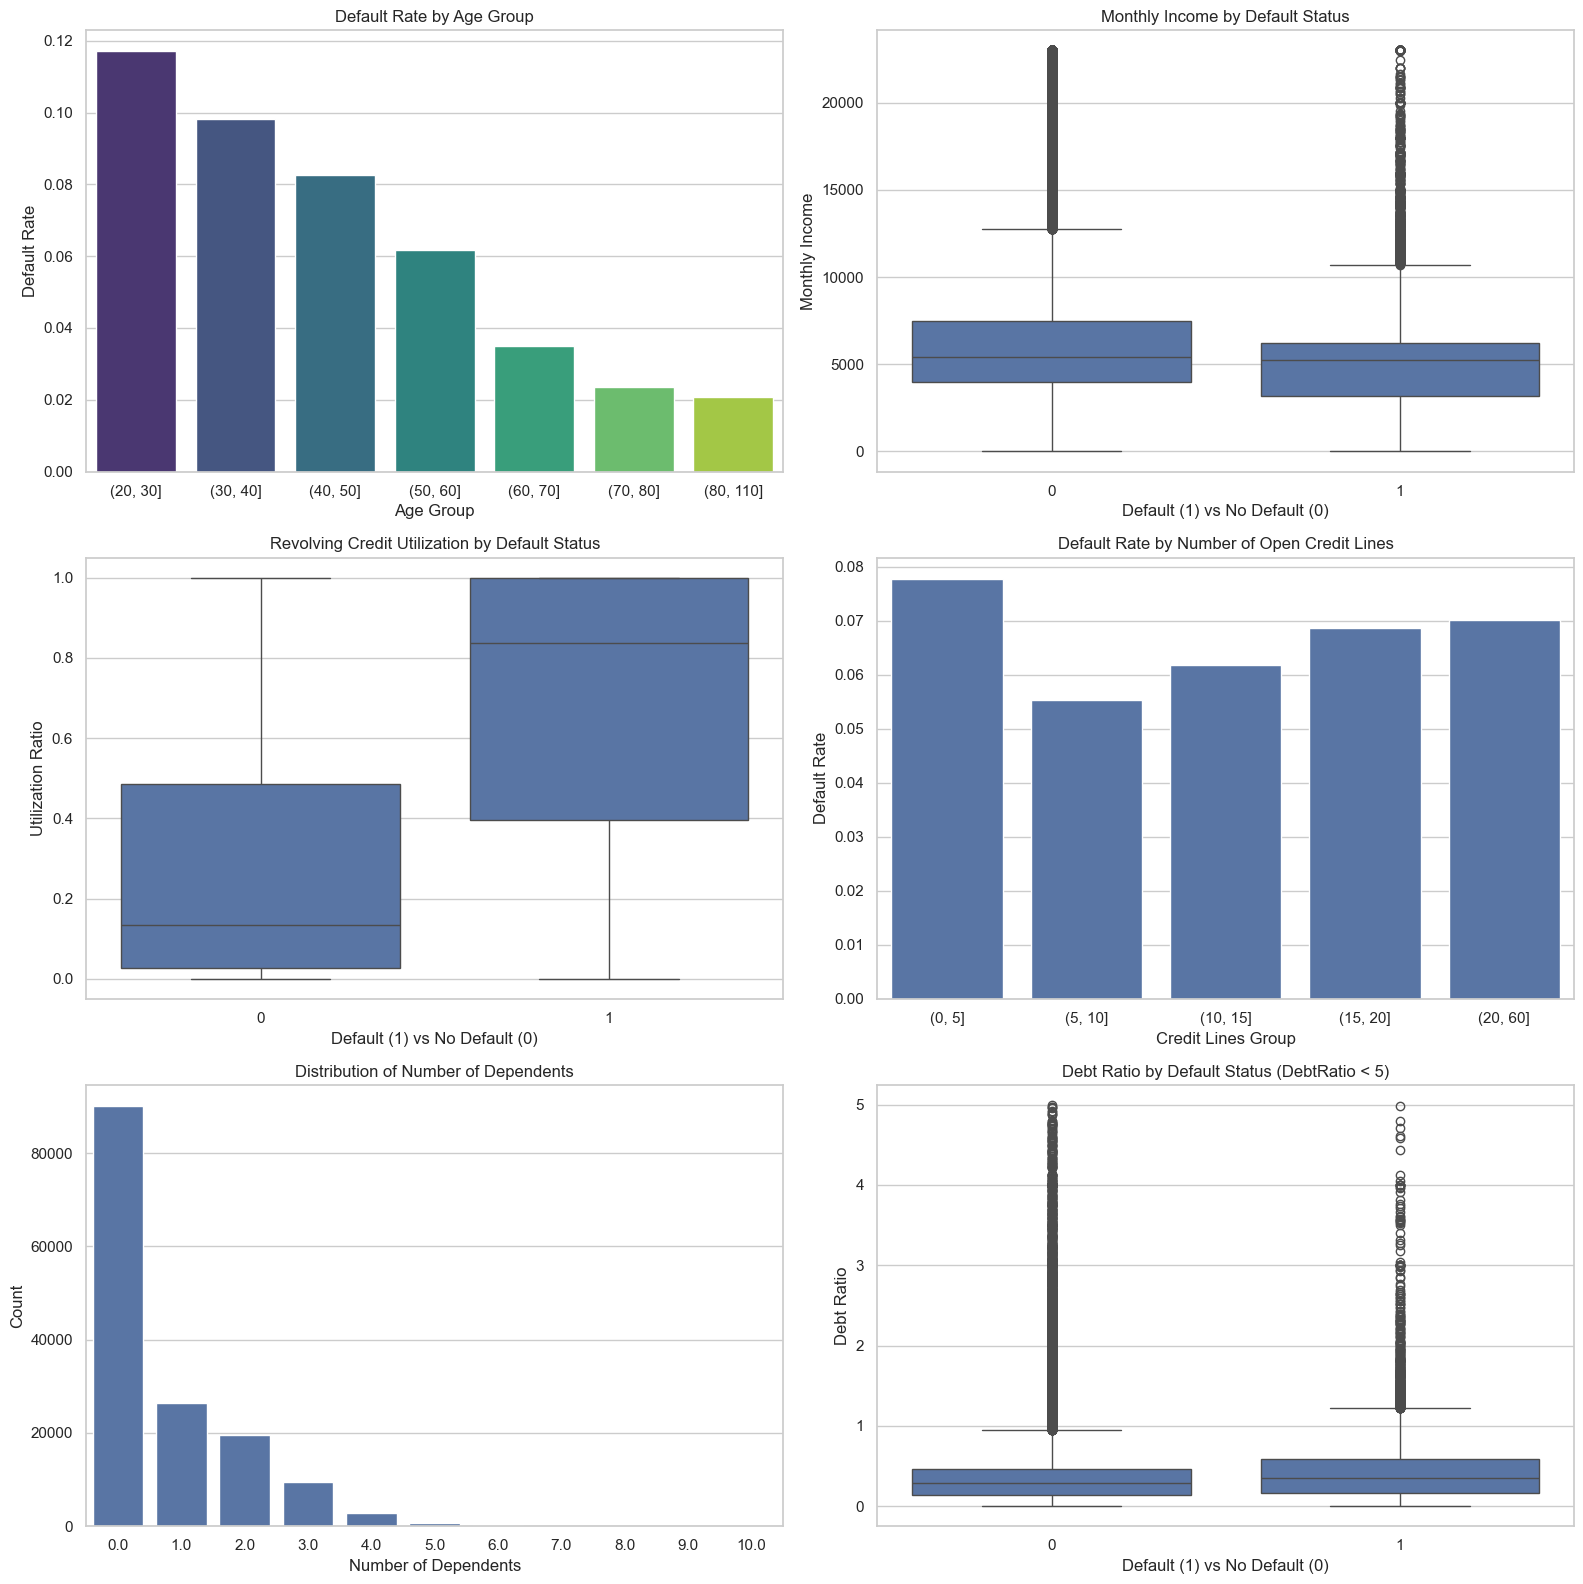

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1. Create Age Groups
df['age_group'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 70, 80, 110])

# 2. Start Plot Grid
fig, axes = plt.subplots(3, 2, figsize=(16, 16))

# -----------------------------
# Plot 1: Default Rate by Age Group
# -----------------------------
age_default = df.groupby('age_group')['SeriousDlqin2yrs'].mean().reset_index()
sns.barplot(ax=axes[0, 0], data=age_default, x='age_group', y='SeriousDlqin2yrs', palette='viridis')
axes[0, 0].set_title('Default Rate by Age Group')
axes[0, 0].set_ylabel('Default Rate')
axes[0, 0].set_xlabel('Age Group')

# -----------------------------
# Plot 2: Monthly Income by Default Status
# -----------------------------
sns.boxplot(ax=axes[0, 1], data=df, x='SeriousDlqin2yrs', y='MonthlyIncome')
axes[0, 1].set_title('Monthly Income by Default Status')
axes[0, 1].set_xlabel('Default (1) vs No Default (0)')
axes[0, 1].set_ylabel('Monthly Income')

# -----------------------------
# Plot 3: Revolving Utilization by Default
# -----------------------------
sns.boxplot(ax=axes[1, 0], data=df, x='SeriousDlqin2yrs', y='RevolvingUtilizationOfUnsecuredLines')
axes[1, 0].set_title('Revolving Credit Utilization by Default Status')
axes[1, 0].set_xlabel('Default (1) vs No Default (0)')
axes[1, 0].set_ylabel('Utilization Ratio')

# -----------------------------
# Plot 4: Default Rate by Number of Credit Lines
# -----------------------------
credit_bins = pd.cut(df['NumberOfOpenCreditLinesAndLoans'], bins=[0, 5, 10, 15, 20, 60])
credit_default = df.groupby(credit_bins)['SeriousDlqin2yrs'].mean().reset_index()
sns.barplot(ax=axes[1, 1], data=credit_default, x='NumberOfOpenCreditLinesAndLoans', y='SeriousDlqin2yrs')
axes[1, 1].set_title('Default Rate by Number of Open Credit Lines')
axes[1, 1].set_ylabel('Default Rate')
axes[1, 1].set_xlabel('Credit Lines Group')

# -----------------------------
# Plot 5: Number of Dependents Distribution
# -----------------------------
sns.countplot(ax=axes[2, 0], data=df, x='NumberOfDependents')
axes[2, 0].set_title('Distribution of Number of Dependents')
axes[2, 0].set_xlabel('Number of Dependents')
axes[2, 0].set_ylabel('Count')

# -----------------------------
# Plot 6: Debt Ratio by Default (Filtered)
# -----------------------------
sns.boxplot(ax=axes[2, 1], data=df[df['DebtRatio'] < 5], x='SeriousDlqin2yrs', y='DebtRatio')
axes[2, 1].set_title('Debt Ratio by Default Status (DebtRatio < 5)')
axes[2, 1].set_xlabel('Default (1) vs No Default (0)')
axes[2, 1].set_ylabel('Debt Ratio')

# -----------------------------
# Layout and Show
# -----------------------------
plt.tight_layout()
plt.show()


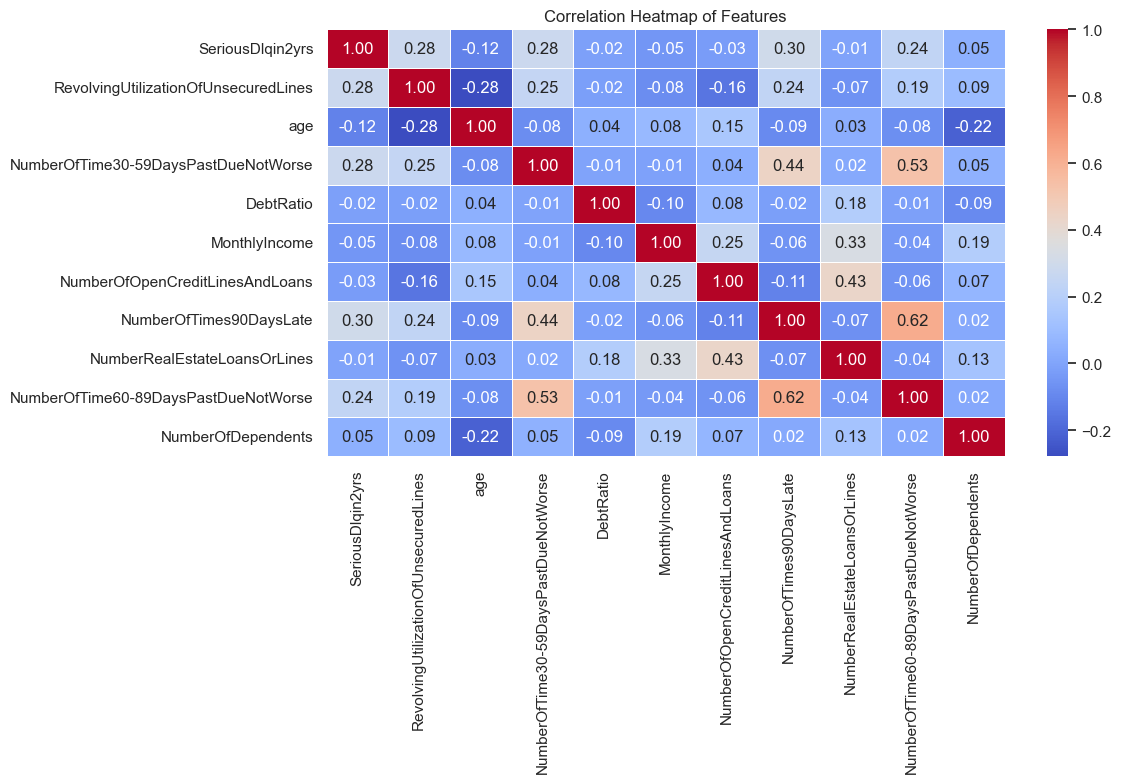

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Compute the correlation matrix
correlation_matrix = df.corr(numeric_only=True)  # `numeric_only=True` avoids future warning

# Step 2: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()


/var/folders/rf/7mxkckvj67n75dgt_jp9hz400000gn/T/ipykernel_43227/4044240976.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='deep')


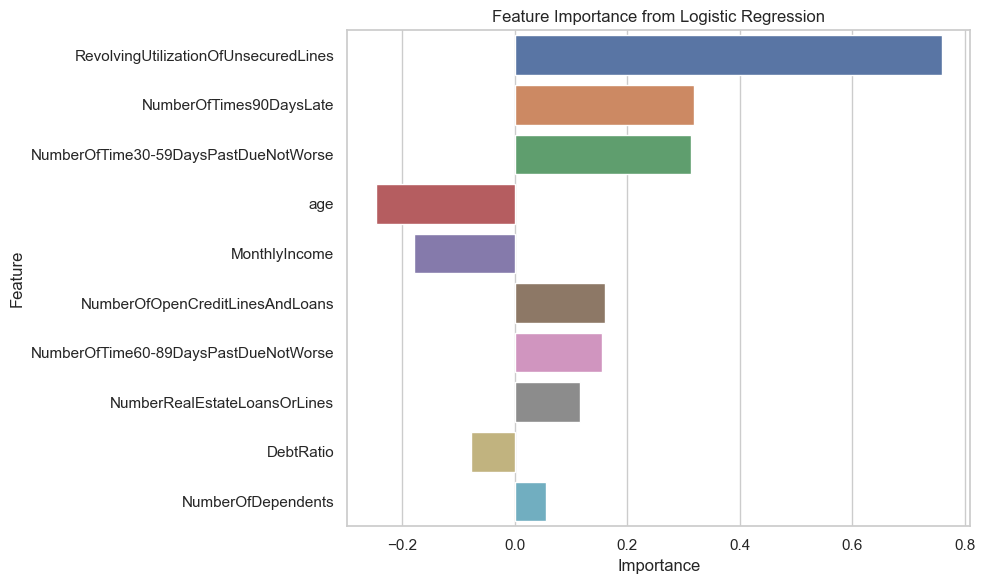

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare features and target
X = df.drop(columns=['SeriousDlqin2yrs', 'age_group'])  # Drop target and temporary column if it exists
y = df['SeriousDlqin2yrs']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# Step 5: Feature importance from model coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': logreg.coef_[0]
}).sort_values(by='Importance', key=abs, ascending=False)

# Step 6: Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='deep')
plt.title('Feature Importance from Logistic Regression')
plt.tight_layout()
plt.show()


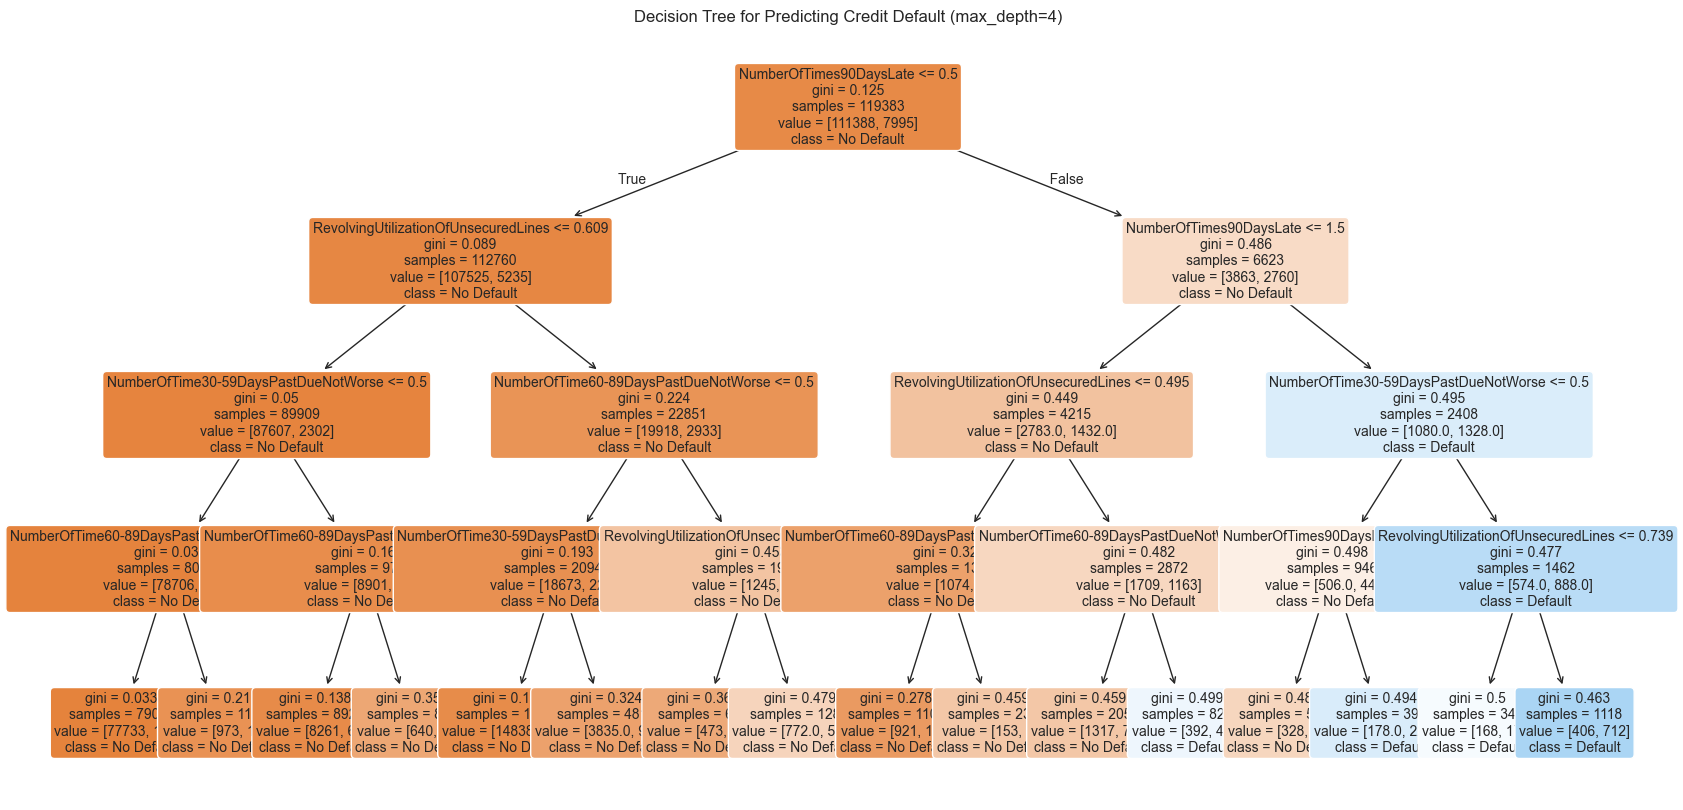

In [10]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Step 1: Train a Decision Tree model
tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

# Step 2: Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model,
          feature_names=X.columns,
          class_names=["No Default", "Default"],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree for Predicting Credit Default (max_depth=4)")
plt.show()
